## Teaching statistical inference with resampling

Copyright 2018 Allen Downey

License: http://creativecommons.org/licenses/by/4.0/

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(4)

## The Euro problem

In *Information Theory, Inference, and Learning Algorithms*, David MacKay writes, "A statistical statement appeared in *The Guardian* on Friday January 4, 2002:

*When spun on edge 250 times, a Belgian one-euro coin came
up heads 140 times and tails 110. ‘It looks very suspicious
to me’, said Barry Blight, a statistics lecturer at the London
School of Economics. ‘If the coin were unbiased the chance of
getting a result as extreme as that would be less than 7%’.*

But do these data give evidence that the coin is biased rather than fair?"

Before we answer MacKay's question, let's unpack what Dr. Blight said:

"If the coin were unbiased the chance of getting a result as extreme as that would be less than 7%".

To see where that comes from, I'll simulate the result of spinning an "unbiased" coin, meaning that the probability of heads is 50%.

Here's an example with 10 spins:

In [2]:
spins = np.random.random(10) < 0.5

array([False, False, False, False, False,  True, False,  True,  True,
        True])

`np.random.random` returns numbers between 0 and 1, uniformly distributed.  So the probability of being less than 0.5 is 50%.  

The sum of the array is the number of `True` elements, that is, the number of heads:

In [3]:
np.sum(spins)

4

We can wrap that in a function that simulates `n` spins with probability `p`. 

In [4]:
def spin(n, p):
    return np.sum(np.random.random(n) < p)

Here's an example with the actual sample size (250) and hypothetical probability (50%).

In [5]:
heads, tails = 140, 110
sample_size = heads + tails

250

In [6]:
hypo_prob = 0.5
spin(sample_size, hypo_prob)

118

Each time we run this simulated experiment, we get a different outcome.

Here's a function that runs the experiment (250 spins) many times, and collects the outcomes (number of heads) in an array.

In [7]:
def run_experiments(n, p, iters):
    t = [spin(n, p) for i in range(iters)]
    return np.array(t)

In [8]:
outcomes = run_experiments(sample_size, hypo_prob, 10000);

The result is an array of 10000 integers, each representing the number of heads in a simulated experiment.  The mean of `outcomes` is about 125:

In [9]:
np.mean(outcomes)

125.0893

Which makes sense.  On average, the expected number of heads is the product of the hypothetical probability and the sample size:

In [10]:
expected = hypo_prob * sample_size

125.0

Let's see how much the values in `outcomes` differ from the expected value:

In [11]:
diffs = outcomes - expected;

The following function plots a histogram of a sequence of values:

In [12]:
def plot_hist(values, low=None, high=None):
    options = dict(alpha=0.5, color='C0')
    xs, ys, patches = plt.hist(values,
                               density=True,
                               histtype='step', 
                               linewidth=3,
                               **options)
    
    
    plt.ylabel('Density')
    plt.tight_layout()
    return patches[0]

Here's what the deviations from the expected value look like:

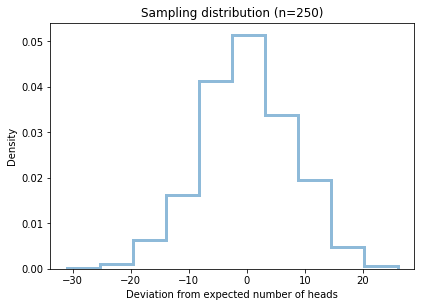

In [13]:
plot_hist(diffs)

plt.title('Sampling distribution (n=250)')
plt.xlabel('Deviation from expected number of heads');

This is the "sampling distribution" of deviations.  It shows how much variation we should expect between experiments with this sample size (n = 250).

## P-values

Getting get back to this line:

"If the coin were unbiased the chance of getting a result as extreme as that would be less than 7%".

Let's count how many times, in 10000 attempts, the outcome is "as extreme as" the observed outcome, 140 heads.

The observed deviation is the difference between the observed and expected number of heads:

In [14]:
observed_diff = heads - expected

15.0

Let's see how many times the simulated `diffs` exceed the observed deviation:

In [15]:
np.mean(diffs >= observed_diff)

0.0313

It's around 3%.  But Dr. Blight said 7%.  Where did that come from?

So far, we only counted the cases where the outcome is *more* heads than expected.  We might also want to count the cases where the outcome is *fewer* than expected.

Here's the probability of falling below the expected number by 15 or more.

In [16]:
np.mean(diffs <= -observed_diff)

0.0334

To get the total probability of a result "as extreme as that", we can use the absolute value of the simulated differences:

In [17]:
np.mean(abs(diffs) >= observed_diff)

0.0647

So that's consistent with what Dr. Blight reported.

To show what that looks like graphically, I'll use the following function, which fills in the histogram between `low` and `high`.

In [18]:
def fill_hist(low, high, patch):
    options = dict(alpha=0.5, color='C0')
    fill = plt.axvspan(low, high, 
                       clip_path=patch,
                       **options)

The following plot shows the sampling distribution of `diffs` with two regions shaded.  These regions represent the probability that an unbiased coin yields a deviation from the expected as extreme as 15.

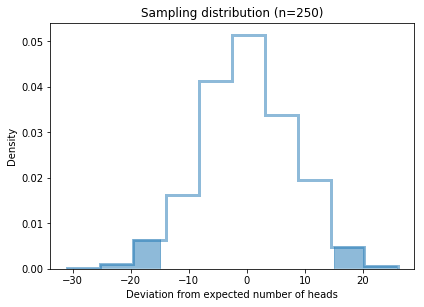

In [19]:
patch = plot_hist(diffs)

low = observed_diff
high = diffs.max()
fill_hist(low, high, patch)

low = diffs.min()
high = -observed_diff
fill_hist(low, high, patch)

plt.title('Sampling distribution (n=250)')
plt.xlabel('Deviation from expected number of heads');

These results show that there is a non-negligible chance of getting a result as extreme as 140 heads, even if the coin is actually fair.

So even if the results are "suspicious" they don't provide compelling evidence that the coin is biased.

## Estimation

Suppose we want to estimate the average height of men in the U.S.

We can use data from the [BRFSS](https://www.cdc.gov/brfss/index.html):

"The Behavioral Risk Factor Surveillance System (BRFSS) is the nation's premier system of health-related telephone surveys that collect state data about U.S. residents regarding their health-related risk behaviors, chronic health conditions, and use of preventive services."

The following function reads the most recent data from BRFSS (2016), selects just the columns we need, and saves the results in an HDF file.

After we run this function, it is much faster to read the HDF file than the original data.

In [20]:
import pandas as pd

def read_brfss():
    """Read the BRFSS dataset, select columns, and save as HDF.
    """
    df = pd.read_sas('LLCP2016.XPT')
    df.head()
    columns = ['SEX', 'HTM4', 'WTKG3', '_LLCPWT']
    selected = df[columns]
    selected.to_hdf('LLCP2016.HDF', 'brfss')

Now we can read the HDF file.  The result is a Pandas DataFrame.

In [21]:
df = pd.read_hdf('LLCP2016.HDF')
df.head()

,SEX,HTM4,WTKG3,_LLCPWT
0,1.0,173.0,6123.0,767.844566
1,2.0,160.0,6940.0,329.659884
2,2.0,165.0,5443.0,290.749306
3,1.0,185.0,9979.0,211.039206
4,1.0,168.0,5670.0,1582.539834


We can use `SEX` to select male respondents.

In [22]:
males = df[df.SEX==1]
len(males)

210606

Then we select height data.

In [23]:
data = males.HTM4
np.mean(np.isnan(data)) * 100

2.894979250353741

About 3% of the values are missing.

Here are the mean and standard deviation, ignoring missing data.

In [24]:
print('Mean male height in cm =', np.nanmean(data))
print('Std male height in cm =', np.nanstd(data))

Mean male height in cm = 178.06121490985726
Std male height in cm = 7.792878100892029


## Quantifying precision

At this point we have an estimate of the average adult male height.  We'd like to know how accurate this estimate is, and how precise.  In the context of estimation, these words have a [technical distinction](https://en.wikipedia.org/wiki/Accuracy_and_precision):

*"Given a set of data points from repeated measurements of the same quantity, the set can be said to be precise if the values are close to each other, while the set can be said to be accurate if their average is close to the true value of the quantity being measured."*

Usually accuracy is what we really care about, but it's hard to measure accuracy unless you know the true value.  And if you know the true value, you don't have to estimate it.

Quantifying precision is not as useful, but it is much easier.  Here's one way to do it:

1.  Use the data you have to make a model of the population.

2.  Use the model to simulate the data collection process.

3.  Use the simulated data to compute an estimate.

4.  Repeat steps 1-3 and collect the results.

To model the population, I'll use **resampling**; that is, I will treat the observed measurements as if they were taken from the entire population, and I will draw random samples from them.

Here's a function that takes observed measurements and returns a new set of measurements with the same sample size.

With `replace=True`, we sample with replacement, which means that some measurements might be chosen more than once, and some might not be chosen at all.

(If we sample *without* replacement, the resampled data is always identical to the original, so that's no good.)

In [25]:
def resample(data):
    size = len(data)
    return np.random.choice(data, size, 
                            replace=True)

To simulate an experiment, we run `resample` to generate data and `nanmean` to compute the mean (ignoring missing data).

In [26]:
resampled_data = resample(data)
np.nanmean(resampled_data)

178.084596120171

And we can simulate 1000 experiments and collect the results.

In [27]:
%time sampling_dist_mean = \
    [np.nanmean(resample(data)) \
     for i in range(1000)];

CPU times: user 4.45 s, sys: 4 ms, total: 4.46 s
Wall time: 4.45 s


The result is the "sampling distribution", which shows how much the results of the experiment would vary if we ran it many times.  Here's what it looks like:

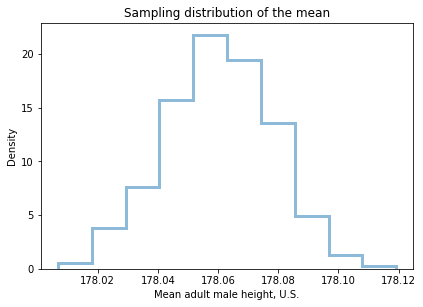

In [28]:
plot_hist(sampling_dist_mean)
plt.title('Sampling distribution of the mean')
plt.xlabel('Mean adult male height, U.S.');

The width of this distribution shows how much the results vary from one experiment to the next.

We can quantify this variability by computing the standard deviation of the sampling distribution, which is called "standard error".


In [29]:
std_err = np.std(sampling_dist_mean)

0.01769828262861241

We can also summarize the sampling distribution with a "confidence interval", which is a range that contains a specified fraction, like 90%, of the values in `sampling_dist_mean`.

The central 90% confidence interval is between the 5th and 95th percentiles of the sampling distribution.

In [30]:
ci_90 = np.percentile(sampling_dist_mean, [5, 95])

array([178.02951276, 178.08952944])

The following function plots a histogram and shades the 90% confidence interval.

In [31]:
def plot_sampling_dist(dist):
    patch = plot_hist(dist)
    low, high = np.percentile(dist, [5, 95])
    fill_hist(low, high, patch)
    print('Mean = ', np.mean(dist))
    print('Std error = ', np.std(dist))
    print('90% CI = ', (low, high))

Here's what it looks like for the sampling distribution of mean adult height:

Mean =  178.06027748143575
Std error =  0.01769828262861241
90% CI =  (178.02951275886966, 178.08952943883128)


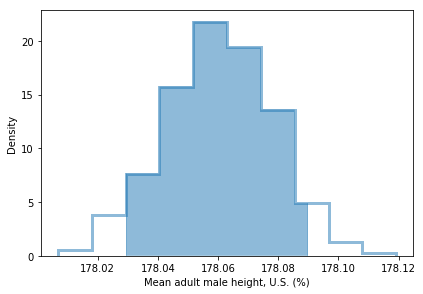

In [32]:
plot_sampling_dist(sampling_dist_mean)
plt.xlabel('Mean adult male height, U.S. (%)');

For an experiment like this, we can compute the standard error analytically.

In [33]:
def analytic_stderr(data):
    size = len(data)
    return np.std(data) / np.sqrt(size)

The result is close to what we observed computationally.

In [34]:
analytic_stderr(data), std_err

(0.01698097071589304, 0.01769828262861241)

## Other sample statistics

One nice thing about using computaton is that it is easy to compute the sampling distribution for other statistics.

For example, suppose we want to estimate the coefficient of variation for adult male height (standard deviation as a percentage of the mean).  We can define a function to compute it:

In [35]:
def coef_var(data):
    return np.nanstd(data) / np.nanmean(data) * 100

And estimate the sampling distribution by running simulated experiments.

In [36]:
sampling_dist_cv = [coef_var(resample(data))
                    for i in range(1000)];

Here's what the sampling distribution of CV looks like:

Mean =  4.3765423194516915
Std error =  0.0096268557742705
90% CI =  (4.361073922387724, 4.391944430007911)


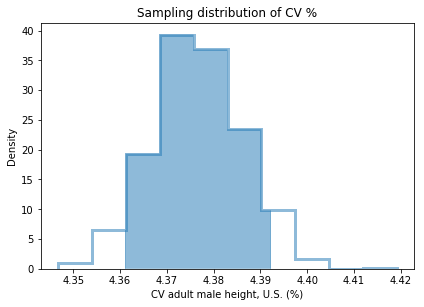

In [37]:
plot_sampling_dist(sampling_dist_cv)
plt.title('Sampling distribution of CV %')
plt.xlabel('CV adult male height, U.S. (%)');

## Weighted resampling

Another nice thing about resampling is that we can extend it to handle the case where the data are weighted.  In fact, the BRFSS deliberately oversamples some groups, so each respondent has a weight that indicates how many people in the population they represent.

The variable `_LLCPWT` contains these weight, which we can normalize so they add up to 1. 

In [38]:
def compute_sampling_weights(df):
    p = df._LLCPWT
    p /= p.sum()
    return p

In [39]:
sampling_weights = compute_sampling_weights(males);

We can pass these weights to `np.random.choice`:

In [40]:
def resample_weighted(data, p):
    size = len(df)
    return np.random.choice(data, size, 
                            replace=True, p=p)

In [41]:
%time sampling_dist_mean_weighted = \
    [np.nanmean(resample_weighted(data, sampling_weights)) \
     for i in range(1000)];

CPU times: user 1min 24s, sys: 3.6 s, total: 1min 28s
Wall time: 1min 28s


If we take the mean of the sampling distribution, we get an estimate of the average male height, taking account of the sampling weights.

In [42]:
xbar_weighted = np.mean(sampling_dist_mean_weighted)

177.54278962889853

And we can compare to the unweighted version:

In [43]:
xbar = np.mean(sampling_dist_mean)

178.06027748143575

With this dataset, the weighted and unweighted estimates are not very different, which probably means there are no substantial differences in height between the groups that are oversampled or undersampled.

## Are first babies more likely to be late?

When my wife and I were expecting our first baby, we heard that first babies are more likely to be late.  We also hear that first babies are more likely to be early.  Neither claim was supported by evidence.

Fortunately, I am a data scientist!  Also fortunately, the CDC runs the National Survey of Family Growth (NSFG), which "gathers information on family life, marriage and divorce, pregnancy, infertility, use of contraception, and men’s and women’s health."

I got the data from their web page, https://www.cdc.gov/nchs/nsfg/index.htm, and wrote some code to get it into a Pandas Dataframe:

In [44]:
import nsfg

df = nsfg.ReadFemPreg()
df.shape

(13593, 244)

The file contains 13,593 rows, one for each pregnancy reported by a one of the survey respondents, and 244, one for each variable.

Here are the first few lines.

In [45]:
df.head()

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw,totalwgt_lb
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,8.8125
1,1,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,7.8750
2,2,1,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,9.1250
3,2,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,7.0000
4,2,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,6.1875


The variables we need are `outcome`, which indicates whether the pregnancy ended in a live birth, `birthord`, which indicates birth order, and `prglength`, which is pregnancy length in weeks.

From all live births, we can select first babies (`birthord==1`) and others:

In [46]:
live = df[df.outcome == 1]
firsts = live[live.birthord == 1]
others = live[live.birthord != 1]

len(firsts), len(others)

(4413, 4735)

Then we can get the list of pregnancy lengths for the two groups and compute their means:

In [47]:
group1 = firsts.prglngth
group2 = others.prglngth

np.mean(group1), np.mean(group2)

(38.60095173351461, 38.52291446673706)

The difference in means is small, about 0.78 weeks.

In [48]:
diff = group1.mean() - group2.mean()

0.07803726677754952

Which is 13 about hours.

In [49]:
diff * 7 * 24

13.11026081862832

So first babies are born about 13 hours later than other babies, on average. 

## Hypothesis testing

The size of this "apparent effect" is small, and we can't tell whether it is real or the result of random sampling.  After all, we did not survey the entire population; we only surveyed a random sample.

There are two ways the sample might deviate from the population:

*  Systematic errors: The pregnancies included in the survey might be different from other pregnancies in a way that biases the results.

*  Sampling errors: The pregnancies lengths in one groups might be a little higher, or lower, than in the other group because of random variability.

We can never rule out the possibility of systematic errors, but usually we can test whether an apparent effect could be explained by random sampling.

Here's how:

1.  Choose a "test statistics" that measures the size of the effect; in this case, the test statistic we started with is the difference in mean pregnancy length.

2.  Use the data to make a model of the population under the assumption that there is actually no difference between the groups.  This assumption is called the "null hypothesis".

3.  Use the model to simulate the data collection process.

4.  Use the simulated data to compute the test statistic.

4.  Repeat steps 2-4 and collect the results.

5.  See how often the simulated test statistic exceeds the observed difference.

The following function computes the test statistic:

In [50]:
def test_stat(data):
    group1, group2 = data
    return group1.mean() - group2.mean()

Here's how we use it.

In [51]:
data = group1, group2
actual = test_stat(data)

0.07803726677754952

Now we need a model of the population under the assumption that these is actually no difference between the groups.

Well, if there's no difference, we can put the two groups together and shuffle them, then divide them at random into two groups with the same sizes.

That's what this function does:

In [52]:
def run_model(data):
    group1, group2 = data
    pool = np.hstack((group1, group2))
    np.random.shuffle(pool)
    n = len(group1)
    return np.split(pool, [n])

Here's how we run it:

In [53]:
run_model(data)

[array([42, 39, 38, ..., 39, 39, 39]), array([39, 38, 39, ..., 39, 39, 39])]

The result is a list of two arrays, which we can pass to `test_stat`:

In [54]:
test_stat(run_model(data))

-0.01127321097717271

That's the result of one simulated experiment.

We can run the experiment 1000 times and collect the results.

In [55]:
test_stat_dist = np.array([test_stat(run_model(data)) 
                           for i in range(1000)])
np.mean(test_stat_dist)

0.0008537509532526997

The result is the "sampling distribution of the test statistic under the null hypothesis".

The mean of this distribution is close to zero, which is not suprising because it is based on the assumption that there is actually no difference between the groups.

Here's a function to plot the distribution of test stats:

In [56]:
def plot_test_stats(test_stats):
    plt.xlabel('Difference in mean (weeks)')
    plt.title('Distribution of test stat under null hypothesis')
    return plot_hist(test_stats)

And here's what it looks like:

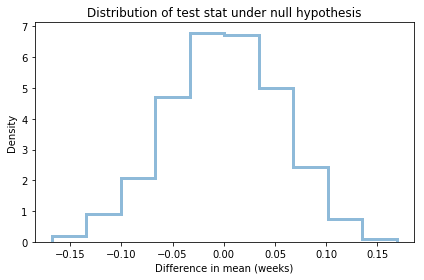

In [57]:
plot_test_stats(test_stat_dist);

Now we can compute the probability that the test statistic, under the null hypothesis, exceeds the observed differences in the means.

This probability is called a "p-value".

In [58]:
p_value = np.mean(test_stat_dist >= actual)

0.075

In this example the p-value is about 8%, which means that the difference we saw, 13 hours, could plausibly occur due to random sampling, even if there is actually no difference between the groups.

The following figure shows the p-value as the shaded area of the distribution above the observed value.

In [59]:
def annotate(text, x, y, length):
    arrowprops = dict(width=1, headwidth=6, facecolor='black')
    plt.annotate(text,
                 xy=(x, y),
                 xytext=(x, y+length),
                 ha='center',
                 arrowprops=arrowprops)

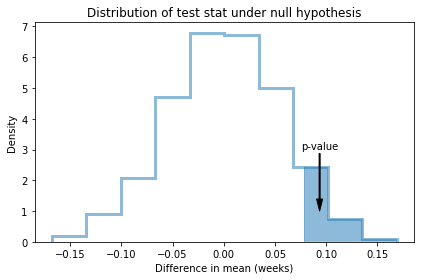

In [60]:
patch = plot_test_stats(test_stat_dist)
low = actual
high = np.max(test_stat_dist)
fill_hist(low, high, patch)
annotate('p-value', 1.2*actual, 1.0, 2)

## Different test statistics

What we computed in the previous section is the probability that first babies would be *later* than 13 hours, on average, under the null hypothesis.

Depending on the context, we might also want to know the probability that first babies would be *earlier* on average.

We can include both possibilities by defining a new test statistic, the *absolute* difference in means.

In [62]:
def test_stat(data):
    group1, group2 = data
    return abs(group1.mean() - group2.mean())

Here's the observed difference with this test stat.

In [63]:
actual = test_stat(data)

0.07803726677754952

Since the actual difference is positive, its absolute value is the same.

We can run the simulated experiments with this test statistic, and print the p-value.

In [64]:
test_stat_dist = np.array([test_stat(run_model(data)) 
                       for i in range(1000)])

p_value = np.mean(test_stat_dist >= actual)

0.156

Here's what the distribution looks like for this test statistic.

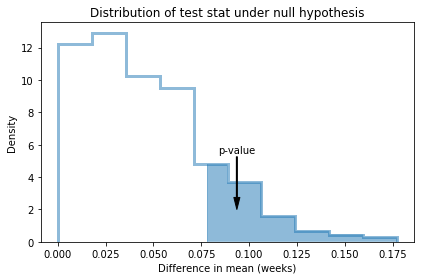

In [65]:
patch = plot_test_stats(test_stat_dist)
low = actual
high = np.max(test_stat_dist)
fill_hist(low, high, patch)
annotate('p-value', 1.2*actual, 2, 3.5)

With this test statistic, the p-value is around 15%, which means is would not be uncommon to see an absolute difference as big as 13 hours, even if there is actually no difference between the groups.

## An object-oriented framework

We can organize the code from the previous sections in a class definition.

In [66]:
class HypothesisTest(object):
    """Represents a hypothesis test."""

    def __init__(self, data):
        """Initializes.

        data: data in whatever form is relevant
        """
        self.data = data
        self.actual = self.test_stat(data)
        self.test_stats = np.array([self.test_stat(self.run_model())
                                    for i in range(1000)])

    def p_value(self):
        """Computes the p-value.

        returns: float p-value
        """
        return np.mean(self.test_stats >= self.actual)

    def plot_test_stats(self):
        """Draws a Cdf with vertical lines at the observed test stat.
        """
        patch = plot_hist(self.test_stats)
        low = self.actual
        high = np.max(self.test_stats)
        fill_hist(low, high, patch)
        plt.title('Distribution of test stat under null')
        
    def test_stat(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        raise UnimplementedMethodException()

    def run_model(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        raise UnimplementedMethodException()

The `HypothesisTest` provides implementations for some methods, because they are the same for all hypothesis tests.

But it leaves some methods unimplemented.  We can write child classes to define the unimplemented methods.

For example, `PermutationTest` implements `run_model` by combining the groups and shuffling them:

In [67]:
class PermutationTest(HypothesisTest):
    """Hypothesis test based on permutation."""

    def run_model(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        n = len(self.data[0])
        pool = np.hstack(self.data)
        np.random.shuffle(pool)
        data = np.split(pool, [n])
        return data

`DiffMeansPermute` extends `PermutationTest` and provides `TestStat`:

In [68]:
class DiffMeansPermute(PermutationTest):
    """Tests a difference in means by permutation."""

    def test_stat(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        group1, group2 = data
        return abs(group1.mean() - group2.mean())

Now we can test the absolute difference in means by permutation:

Diff means permute pregnancy length
actual = 0.07803726677754952
p-value = 0.163


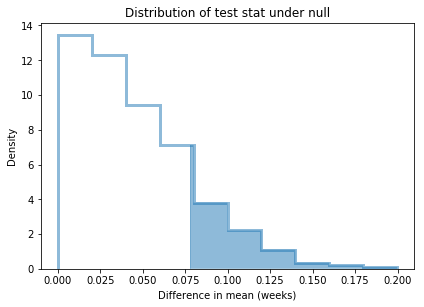

In [69]:
ht = DiffMeansPermute(data)
p_value = ht.p_value()

print('Diff means permute pregnancy length')
print('actual =', ht.actual)
print('p-value =', p_value)
ht.plot_test_stats()
plt.xlabel('Difference in mean (weeks)');

## Different test statistic

It's easy to run a test with a different test statistic.  For example, if we think that first babies might be more variable than others, we could use the difference in standard deviation:

In [70]:
class DiffStdPermute(PermutationTest):
    """Tests a difference in standard deviation by permutation."""

    def test_stat(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        group1, group2 = data
        return abs(group1.std() - group2.std())

Here are the results

Diff std permute pregnancy length
actual = 0.1760490642294399
p-value = 0.157


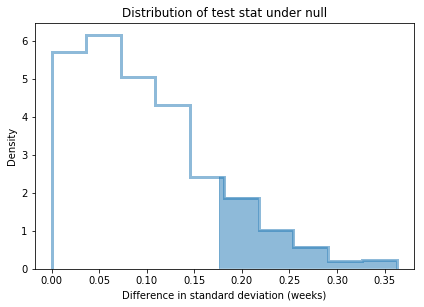

In [71]:
ht = DiffStdPermute(data)
p_value = ht.p_value()

print('Diff std permute pregnancy length')
print('actual =', ht.actual)
print('p-value =', p_value)
ht.plot_test_stats()
plt.xlabel('Difference in standard deviation (weeks)');

The observed difference in standard deviation is about 0.17 weeks.

The p-value is around 17%, which indicates that, even if there is actually no difference between the groups, there is a non-negligible chance that we could see a difference in standard deviation as big as 0.17 weeks due to random sampling.

## Different model

It's also easy to run with a different model.  Instead of shuffling the observed data, we could use the data to choose the parameters of a normal distribution, and then draw random samples:

In [72]:
class RandomNormalTest(HypothesisTest):
    """Tests by drawing values from a normal distribution."""

    def run_model(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        n = len(self.data[0])
        pool = np.hstack(self.data)
        mu, sigma = np.mean(pool), np.std(pool)
        random = np.random.normal(mu, sigma, len(pool))
        data = np.split(random, [n])
        return data

Now we can make a class that tests a difference in means by drawing values from a normal distribution:

In [73]:
class DiffMeansNormal(PermutationTest):
    """Tests a difference in means using a normal distribution."""
    
    test_stat = DiffMeansPermute.test_stat

And here are the results:

Diff means normal pregnancy length
actual = 0.07803726677754952
p-value = 0.17


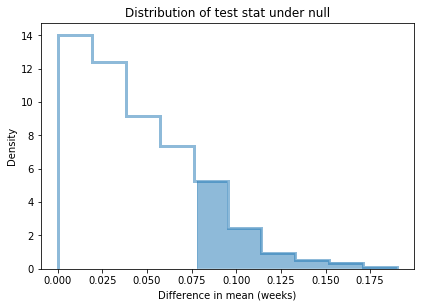

In [74]:
ht = DiffMeansNormal(data)
p_value = ht.p_value()

print('Diff means normal pregnancy length')
print('actual =', ht.actual)
print('p-value =', p_value)
ht.plot_test_stats()
plt.xlabel('Difference in mean (weeks)');

The results from this model are not substantially different, which suggests that they do not depend on arbitrary modeling decisions, and that's good.

For this example, the permutation test is probably better because it does not make any assumptions about the distribution of pregnancy lengths.

If the sample size were substantially smaller, the model that draws from the normal distribution might be better.